In [1]:
import numpy as np
import csv
import math
import itertools

def read_csv(file_path):
    data = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader, None)  # Skip the header row
        for row in reader:
            data.append([float(val) for val in row])
    return data

def euclidean_distance(point1, point2):
    return math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))

def affinity_propagation(data, damping=0.5, max_iter=300, availability_threshold=0.5, convergence_iter=15, preference=None):
    n_instances = len(data)
    n_features = len(data[0])

    if preference is None:
        preference = -np.median(np.abs(data))

    similarity_matrix = np.array([
        [math.sqrt(sum((data[i][k] - data[j][k]) ** 2 for k in range(n_features))) + preference for j in range(n_instances)]
        for i in range(n_instances)
    ])

    responsibility = np.zeros((n_instances, n_instances))
    availability = np.zeros((n_instances, n_instances))

    for iteration in range(max_iter):
        temp = similarity_matrix + availability
        max_temp = np.max(temp, axis=1, keepdims=True)
        responsibility = np.where(temp == max_temp, similarity_matrix, np.maximum(temp - max_temp, 0))

        max_resp = np.maximum(0, np.sum(responsibility, axis=0) - np.diagonal(responsibility))
        availability = damping * availability + (1 - damping) * max_resp

        if np.all(availability < availability_threshold) or iteration >= convergence_iter:
            break

    exemplars = [j for j in range(n_instances) if any(responsibility[i][j] + availability[i][j] > 0 for i in range(n_instances))]

    if not exemplars:
        return [[] for _ in range(n_instances)]

    clusters = [[] for _ in range(len(exemplars))]
    for i in range(n_instances):
        nearest_exemplar = min(exemplars, key=lambda j: similarity_matrix[i][j])
        clusters[exemplars.index(nearest_exemplar)].append(i)

    return clusters

def calculate_silhouette_scores(data, clusters):
    silhouette_scores = []
    cluster_silhouette_scores = {}

    for idx, cluster in enumerate(clusters):
        cluster_key = tuple(cluster)  # Convert the list to a tuple
        cluster_silhouette_scores[cluster_key] = []

        for i in cluster:
            a_i = np.mean([euclidean_distance(data[i], data[j]) for j in cluster if i != j])

            b_i_values = []
            for other_cluster in clusters:
                if other_cluster != cluster:
                    b_i_values.append(np.mean([euclidean_distance(data[i], data[j]) for j in other_cluster]))

            b_i = min(b_i_values) if b_i_values else 0
            silhouette_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0
            silhouette_scores.append(silhouette_i)
            cluster_silhouette_scores[cluster_key].append(silhouette_i)

    return silhouette_scores, cluster_silhouette_scores

def generate_range(start, end, step):
    return [start + i * step for i in range(int((end - start) / step) + 1)]

# Example usage:
file_path = '../dataset/beforeDS.csv'
data = read_csv(file_path)

original_data = data

normalized_data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Define ranges and step sizes for parameter values
damping_values = generate_range(0.1, 0.5, 0.1)
availability_threshold_values = generate_range(0.1, 0.5, 0.1)
convergence_iter_values = generate_range(5, 40, 5)
preference_values = generate_range(-0.5, -1.5, -0.1)

best_silhouette_score = float('-inf')
best_parameters = {}

# Perform grid search
for damping, availability_threshold, convergence_iter, preference in itertools.product(
        damping_values, availability_threshold_values, convergence_iter_values, preference_values):
    
    clusters = affinity_propagation(normalized_data, damping=damping,
                                    availability_threshold=availability_threshold,
                                    convergence_iter=convergence_iter, preference=preference)

    silhouette_scores, _ = calculate_silhouette_scores(normalized_data, clusters)
    average_silhouette = np.mean(silhouette_scores)

    if average_silhouette > best_silhouette_score:
        best_silhouette_score = average_silhouette
        best_parameters = {
            'damping': damping,
            'availability_threshold': availability_threshold,
            'convergence_iter': convergence_iter,
            'preference': preference
        }
silhouette_scores, cluster_silhouette_scores = calculate_silhouette_scores(normalized_data, clusters)

# Print silhouette scores for each cluster
for cluster, scores in cluster_silhouette_scores.items():
    avg_silhouette = np.mean(scores)

# Print overall average silhouette score across all clusters
overall_avg_silhouette = np.mean(silhouette_scores)
#print(f"Overall Average Silhouette Score: {overall_avg_silhouette}")

# Print the best parameters and silhouette score
print("Best Parameters:")
print(best_parameters)
print("Best Silhouette Score:", best_silhouette_score)


Best Parameters:
{'damping': 0.1, 'availability_threshold': 0.1, 'convergence_iter': 5, 'preference': -1.3}
Best Silhouette Score: 0.2576462023572559


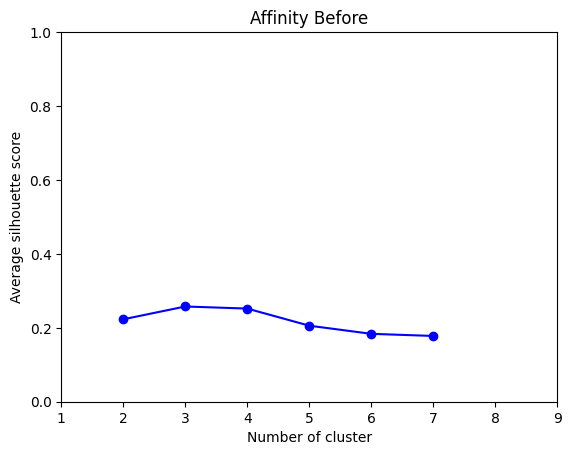

In [7]:
import csv
import matplotlib.pyplot as plt

def plot_line_graph(file_path, x_axis_limit=None, y_axis_limit=None):
    x_values = []
    y_values = []

    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader, None)  # Skip the header row
        for row in reader:
            if row[0].strip() and row[1].strip():  # Check if both values are non-empty
                x_values.append(float(row[0]))
                y_values.append(float(row[1]))


    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')  # Adjust color and style as needed
    plt.title('Affinity Before')
    plt.xlabel('Number of cluster')
    plt.ylabel('Average silhouette score')

    if x_axis_limit is not None:
        plt.xlim(x_axis_limit)
    
    if y_axis_limit is not None:
        plt.ylim(y_axis_limit)

    plt.show()

# Example usage with custom axis limits:
csv_file_path = '../Results/Affinity/Affinity_Before/affinity_beforeDS_TotalResult.csv'  # Provide the actual path to your CSV file
x_limit = (1, 9)  # Specify the desired x-axis limits
y_limit = (0, 1)  # Specify the desired y-axis limits
plot_line_graph(csv_file_path, x_axis_limit=x_limit, y_axis_limit=y_limit)